# Análise de Compras Diretas na Loja com Regressão

## Introdução
Este notebook desenvolve um modelo de classificação utilizando redes neurais para prever o número de compras feitas em diretamente em lojas com base no perfil dos consumidores. Vamos importar as principais bibliotecas:


In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Normalization
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fixando a semente para numpy e tensorflow para garantir a reproducibilidade
general_random_state = 1

np.random.seed(general_random_state)
tf.random.set_seed(general_random_state)


## Carregamento de Dados
Carregamos os dados necessários para o modelo.

In [2]:

# Carrega o dataset
data_path = 'ifood_df.csv'
data = pd.read_csv(data_path)
data.head()
target_col = 'NumStorePurchases'

## Análise Exploratória de Dados (EDA)
Realizando uma análise visual inicial dos dados para entender suas características. Primeiro, visualizamos todos os histogramas de todas as colunas do dataset:

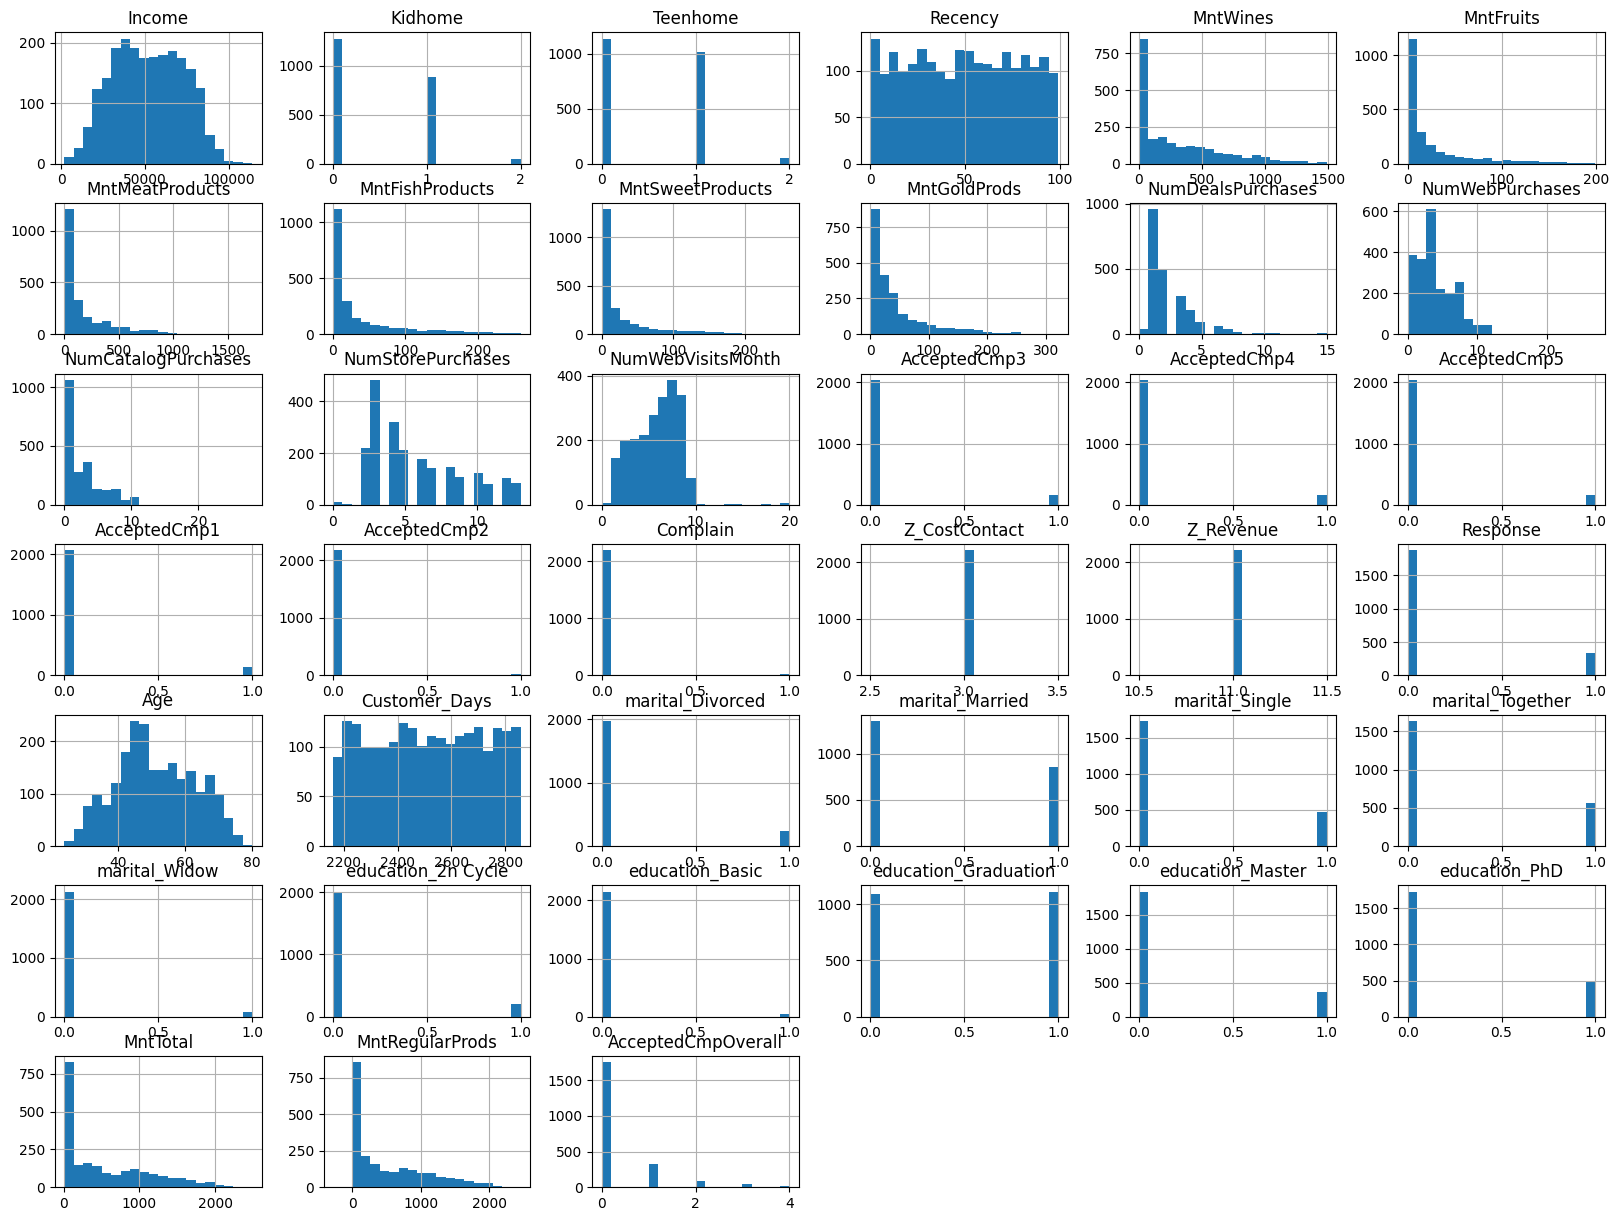

In [3]:
# Histograma de todas as características
data.hist(bins=20, figsize=(20,15))
plt.show()


Visualizando a distribuição dentro da classe alvo, onde os valores expressão o número de compras que cada cliente fez diretamente nas lojas:


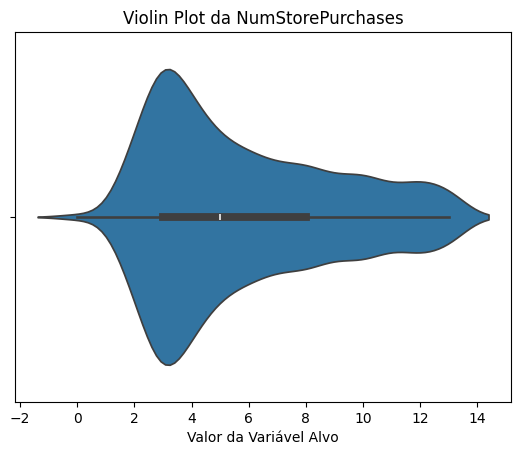

In [4]:
sns.violinplot(x=data[target_col])
plt.title(f"Violin Plot da {target_col}")
plt.xlabel(f"Valor da Variável Alvo")
plt.show()

Verificando ruídos, se há duplicatas ou valores nulos

In [5]:
for col in data.columns:
    duplicates_per_column = data.duplicated(subset=[col]).sum()
    if duplicates_per_column > 0:
        print(f"Duplicatas na coluna {col}: {duplicates_per_column}")

    nulls_per_column = data[col].isnull().sum()
    if nulls_per_column > 0:
        print(f"Valores nulos na coluna {col}: {nulls_per_column}")

Duplicatas na coluna Income: 242
Duplicatas na coluna Kidhome: 2202
Duplicatas na coluna Teenhome: 2202
Duplicatas na coluna Recency: 2105
Duplicatas na coluna MntWines: 1430
Duplicatas na coluna MntFruits: 2047
Duplicatas na coluna MntMeatProducts: 1654
Duplicatas na coluna MntFishProducts: 2023
Duplicatas na coluna MntSweetProducts: 2029
Duplicatas na coluna MntGoldProds: 1993
Duplicatas na coluna NumDealsPurchases: 2190
Duplicatas na coluna NumWebPurchases: 2190
Duplicatas na coluna NumCatalogPurchases: 2192
Duplicatas na coluna NumStorePurchases: 2191
Duplicatas na coluna NumWebVisitsMonth: 2189
Duplicatas na coluna AcceptedCmp3: 2203
Duplicatas na coluna AcceptedCmp4: 2203
Duplicatas na coluna AcceptedCmp5: 2203
Duplicatas na coluna AcceptedCmp1: 2203
Duplicatas na coluna AcceptedCmp2: 2203
Duplicatas na coluna Complain: 2203
Duplicatas na coluna Z_CostContact: 2204
Duplicatas na coluna Z_Revenue: 2204
Duplicatas na coluna Response: 2203
Duplicatas na coluna Age: 2149
Duplicatas n

Verificando os principais quartis e tendencias do dataset

In [6]:
display(data.describe())

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.00000
mean,51622.094785,0.442177,0.506576,49.009070,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,0.257596,0.034467,0.089796,0.024490,0.504762,0.165079,0.215873,562.764626,518.707483,0.29932
std,20713.063826,0.537132,0.544380,28.932111,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,...,0.437410,0.182467,0.285954,0.154599,0.500091,0.371336,0.411520,575.936911,553.847248,0.68044
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,-283.000000,0.00000
25%,35196.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,42.000000,0.00000
50%,51287.000000,0.000000,0.000000,49.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,343.000000,288.000000,0.00000
75%,68281.000000,1.000000,1.000000,74.000000,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,964.000000,884.000000,0.00000
max,113734.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2491.000000,2458.000000,4.00000


Verificando as correlações com a classe alvo do dataset

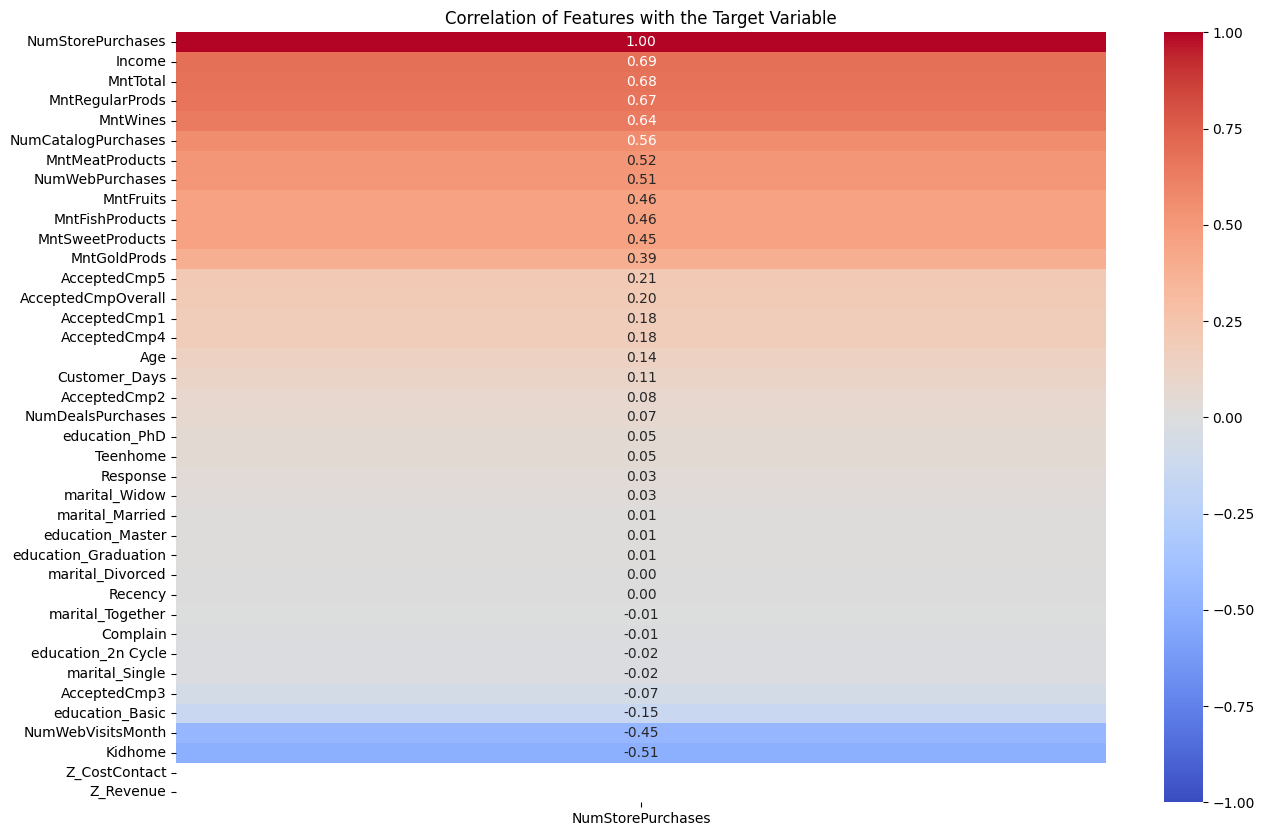

In [7]:
# Calcula as correlações
correlations = data.corr()

# Plota a correlação das características com a variável alvo 'Bankrupt?'
plt.figure(figsize=(15, 10))
sns.heatmap(correlations[[target_col]].sort_values(by=target_col, ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation of Features with the Target Variable')
plt.show()

## Pré-processamento de Dados
Reduzindo o desbalanceamento da classe principal, e em seguida visualizando o novo balanceamento das classes:

Removendo as colunas de baixa variância

In [8]:
# Remove colunas de baixa variância
data_var = data.var()
low_variance_cols = data_var[data_var < 0.01].index.tolist()
data_cleaned = data.drop(columns=low_variance_cols)

Removendo colunas que possuem alta correlação

In [9]:
correlation_matrix = data_cleaned.corr().abs()

# Selecione o triângulo superior da matriz de correlação
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encontre as colunas com correlação maior que 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Remova as colunas
data_dropped = data_cleaned.drop(to_drop, axis=1)

Tratando outliers

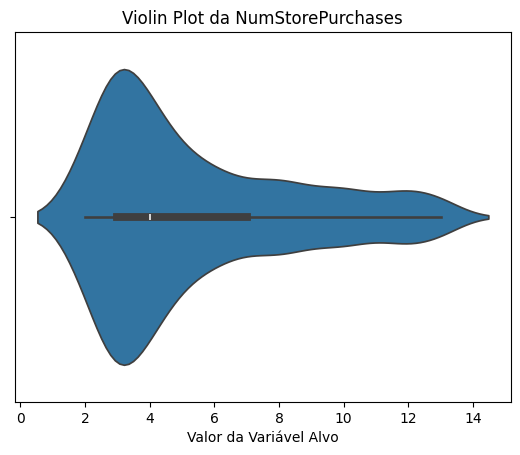

In [10]:
# Identificando e tratando outliers (exemplo usando z-score ou IQR)
data_dropped = data_dropped[(np.abs(stats.zscore(data_dropped)) < 3).all(axis=1)]

sns.violinplot(x=data_dropped[target_col])

plt.title(f"Violin Plot da {target_col}")
plt.xlabel(f"Valor da Variável Alvo")
plt.show()

Separando os dados para os modelos


In [11]:
data_final = data_dropped
# Separa características e variável alvo
features = data_final.drop(columns=target_col)
target = data_final[target_col]

# Divide os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=general_random_state)

# Padroniza as características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
data_final.head()



,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,1,0,0,0,0,1,0,0,1529,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,1,0,0,0,0,1,0,0,21,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,1,0,0,0,1,0,0,734,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,1,0,0,0,1,0,0,48,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,0,1,407,0


## Construção e Treinamento do Modelo de Regressão Linear
Definimos e treinamos nosso modelo de regressão linear.

In [25]:
normalizer = Normalization()
normalizer.adapt(X_train_scaled)

camadas = [
    normalizer,
    layers.Dense(1, activation='linear')
]

# Constrói o modelo de regressão linear
model_reg_linear = models.Sequential(deepcopy(camadas))

# Compila o modelo
model_reg_linear.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Treina o modelo
history = model_reg_linear.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 36.8928 - mean_absolute_error: 5.3537 - val_loss: 32.2767 - val_mean_absolute_error: 5.1904
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.6924 - mean_absolute_error: 5.0414 - val_loss: 28.9241 - val_mean_absolute_error: 5.0020
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.4918 - mean_absolute_error: 4.8042 - val_loss: 26.6921 - val_mean_absolute_error: 4.8028
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0988 - mean_absolute_error: 4.5763 - val_loss: 24.6374 - val_mean_absolute_error: 4.5920
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.9768 - mean_absolute_error: 4.3567 - val_loss: 22.7036 - val_mean_absolute_error: 4.3849
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.0511 - mean_absolute_error: 4.1479 - val_loss: 20.8948 - val_mean_absolute_error: 4.1877
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.2942 - mean_absolute_error: 3.9488 - va

## Avaliação do Modelo e Determinação da Melhor Época para Parar o Treinamento

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4591 - mean_absolute_error: 1.3136 
Test accuracy: 1.3186155557632446


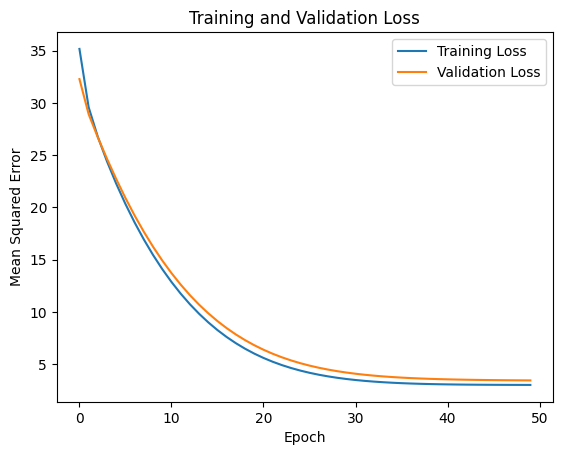

In [26]:
test_loss_reg_linear, test_acc_reg_linear = model_reg_linear.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc_reg_linear}')

# Visualização de Loss e MAE durante o Treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


## Visualização de Perda durante o Treinamento
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair a partir da quinta epoca de treino, o que indica que esta é aproximadamente a melhor época para parar de treinar e não gerar overfitting, e ainda sim obter um modelo satisfatório

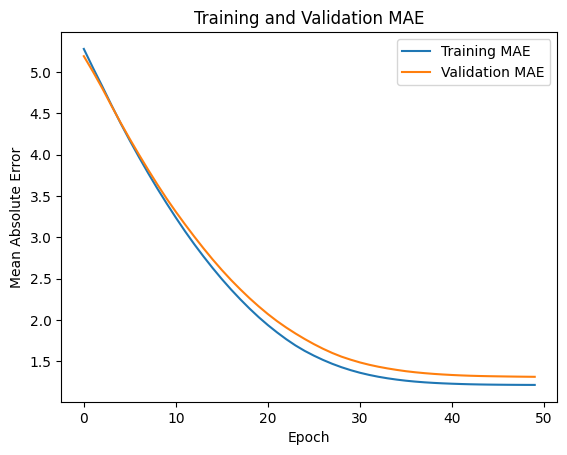

In [27]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

## Treinando com um número de épocas fixo
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair significativamente a partir da 5ª epoca de treino. As melhores épocas para treinar um modelo definitivo estão entre a 5ª e a 20ª aproximadamente, provendo uma acurácia satisfatória, e sem overfitting. Vamos retreinar considerando a 12ª época:

In [30]:
## Retreinamento com um número de épocas otimizado
# Constrói o modelo de rede neural final
final_model_reg_linear = models.Sequential(deepcopy(camadas))

# Compilação do modelo
final_model_reg_linear.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Treinamento do modelo com número de épocas reduzido
history = final_model_reg_linear.fit(X_train_scaled, y_train, epochs=12,
                                     validation_split=0.2)

# Avaliação do modelo final
final_test_loss_reg_linear, final_test_mae_reg_linear = \
  final_model_reg_linear.evaluate(X_test_scaled, y_test)
print(f'Final Test MAE: {final_test_mae_reg_linear}')

Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 44.0943 - mean_absolute_error: 5.4831 - val_loss: 35.8024 - val_mean_absolute_error: 5.2220
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.7591 - mean_absolute_error: 5.1439 - val_loss: 30.0804 - val_mean_absolute_error: 5.0142
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.6978 - mean_absolute_error: 4.8754 - val_loss: 27.2957 - val_mean_absolute_error: 4.8342
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24.8426 - mean_absolute_error: 4.6428 - val_loss: 25.1250 - val_mean_absolute_error: 4.6315
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.5418 - mean_absolute_error: 4.4159 - val_loss: 23.1402 - val_mean_absolute_error: 4.4273
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.5026 - mean_absolute_error: 4.1966 - val_loss: 21.2963 - val_mean_absolute_error: 4.2288
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.6624 - mean_absolute_error: 3.9883 - v

Uma época relativamente avançada, dentro do intervalo proposto ou até mais também pode ser selecionada, visando adquirir uma margem de erro (MAE ou MSE) menor, o que significaria números mais precisos, mas também reduziria o potencial do modelo em generalizar respostas para caso não previstos devido a uma especialização muito forte.

## Construção e Treinamento do Modelo de Árvore de Decisão
Definimos e treinamos nosso modelo de árvore de decisão.

In [12]:
# Definir o grid de parâmetros
param_grid = {
    'max_depth': [num for num in range(1, 20)],
}

# Instanciar o modelo
tree_regr = DecisionTreeRegressor(random_state=general_random_state)

# Configurar a busca em grid, para selecionar automáticamente os melhores
# parâmetros da árvore
grid_search = GridSearchCV(estimator=tree_regr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Treinar o modelo
grid_search.fit(X_train, y_train)

# Obter o melhor modelo e previsões
best_tree = grid_search.best_estimator_
y_pred_best = best_tree.predict(X_test)

# Avaliar o melhor modelo
best_mse = mean_squared_error(y_test, y_pred_best)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

# Exibir os resultados
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor MSE:", best_mse)
print("Melhor MAE:", best_mae)
print("Melhor R²:", best_r2)


Melhores parâmetros: {'max_depth': 5}
Melhor MSE: 3.9167657138651957
Melhor MAE: 1.252565631819886
Melhor R²: 0.5970569416194009


Visualizando a árvore de decisão gerada

|--- MntTotal <= 388.00
|   |--- MntTotal <= 203.00
|   |   |--- MntTotal <= 115.50
|   |   |   |--- MntTotal <= 21.50
|   |   |   |   |--- NumWebPurchases <= 0.50
|   |   |   |   |   |--- value: [2.94]
|   |   |   |   |--- NumWebPurchases >  0.50
|   |   |   |   |   |--- value: [2.24]
|   |   |   |--- MntTotal >  21.50
|   |   |   |   |--- NumCatalogPurchases <= 0.50
|   |   |   |   |   |--- value: [3.19]
|   |   |   |   |--- NumCatalogPurchases >  0.50
|   |   |   |   |   |--- value: [2.69]
|   |   |--- MntTotal >  115.50
|   |   |   |--- Income <= 29597.50
|   |   |   |   |--- MntFruits <= 14.50
|   |   |   |   |   |--- value: [2.17]
|   |   |   |   |--- MntFruits >  14.50
|   |   |   |   |   |--- value: [4.00]
|   |   |   |--- Income >  29597.50
|   |   |   |   |--- NumWebVisitsMonth <= 5.50
|   |   |   |   |   |--- value: [4.35]
|   |   |   |   |--- NumWebVisitsMonth >  5.50
|   |   |   |   |   |--- value: [3.80]
|   |--- MntTotal >  203.00
|   |   |--- NumWebVisitsMonth <= 5.50
|

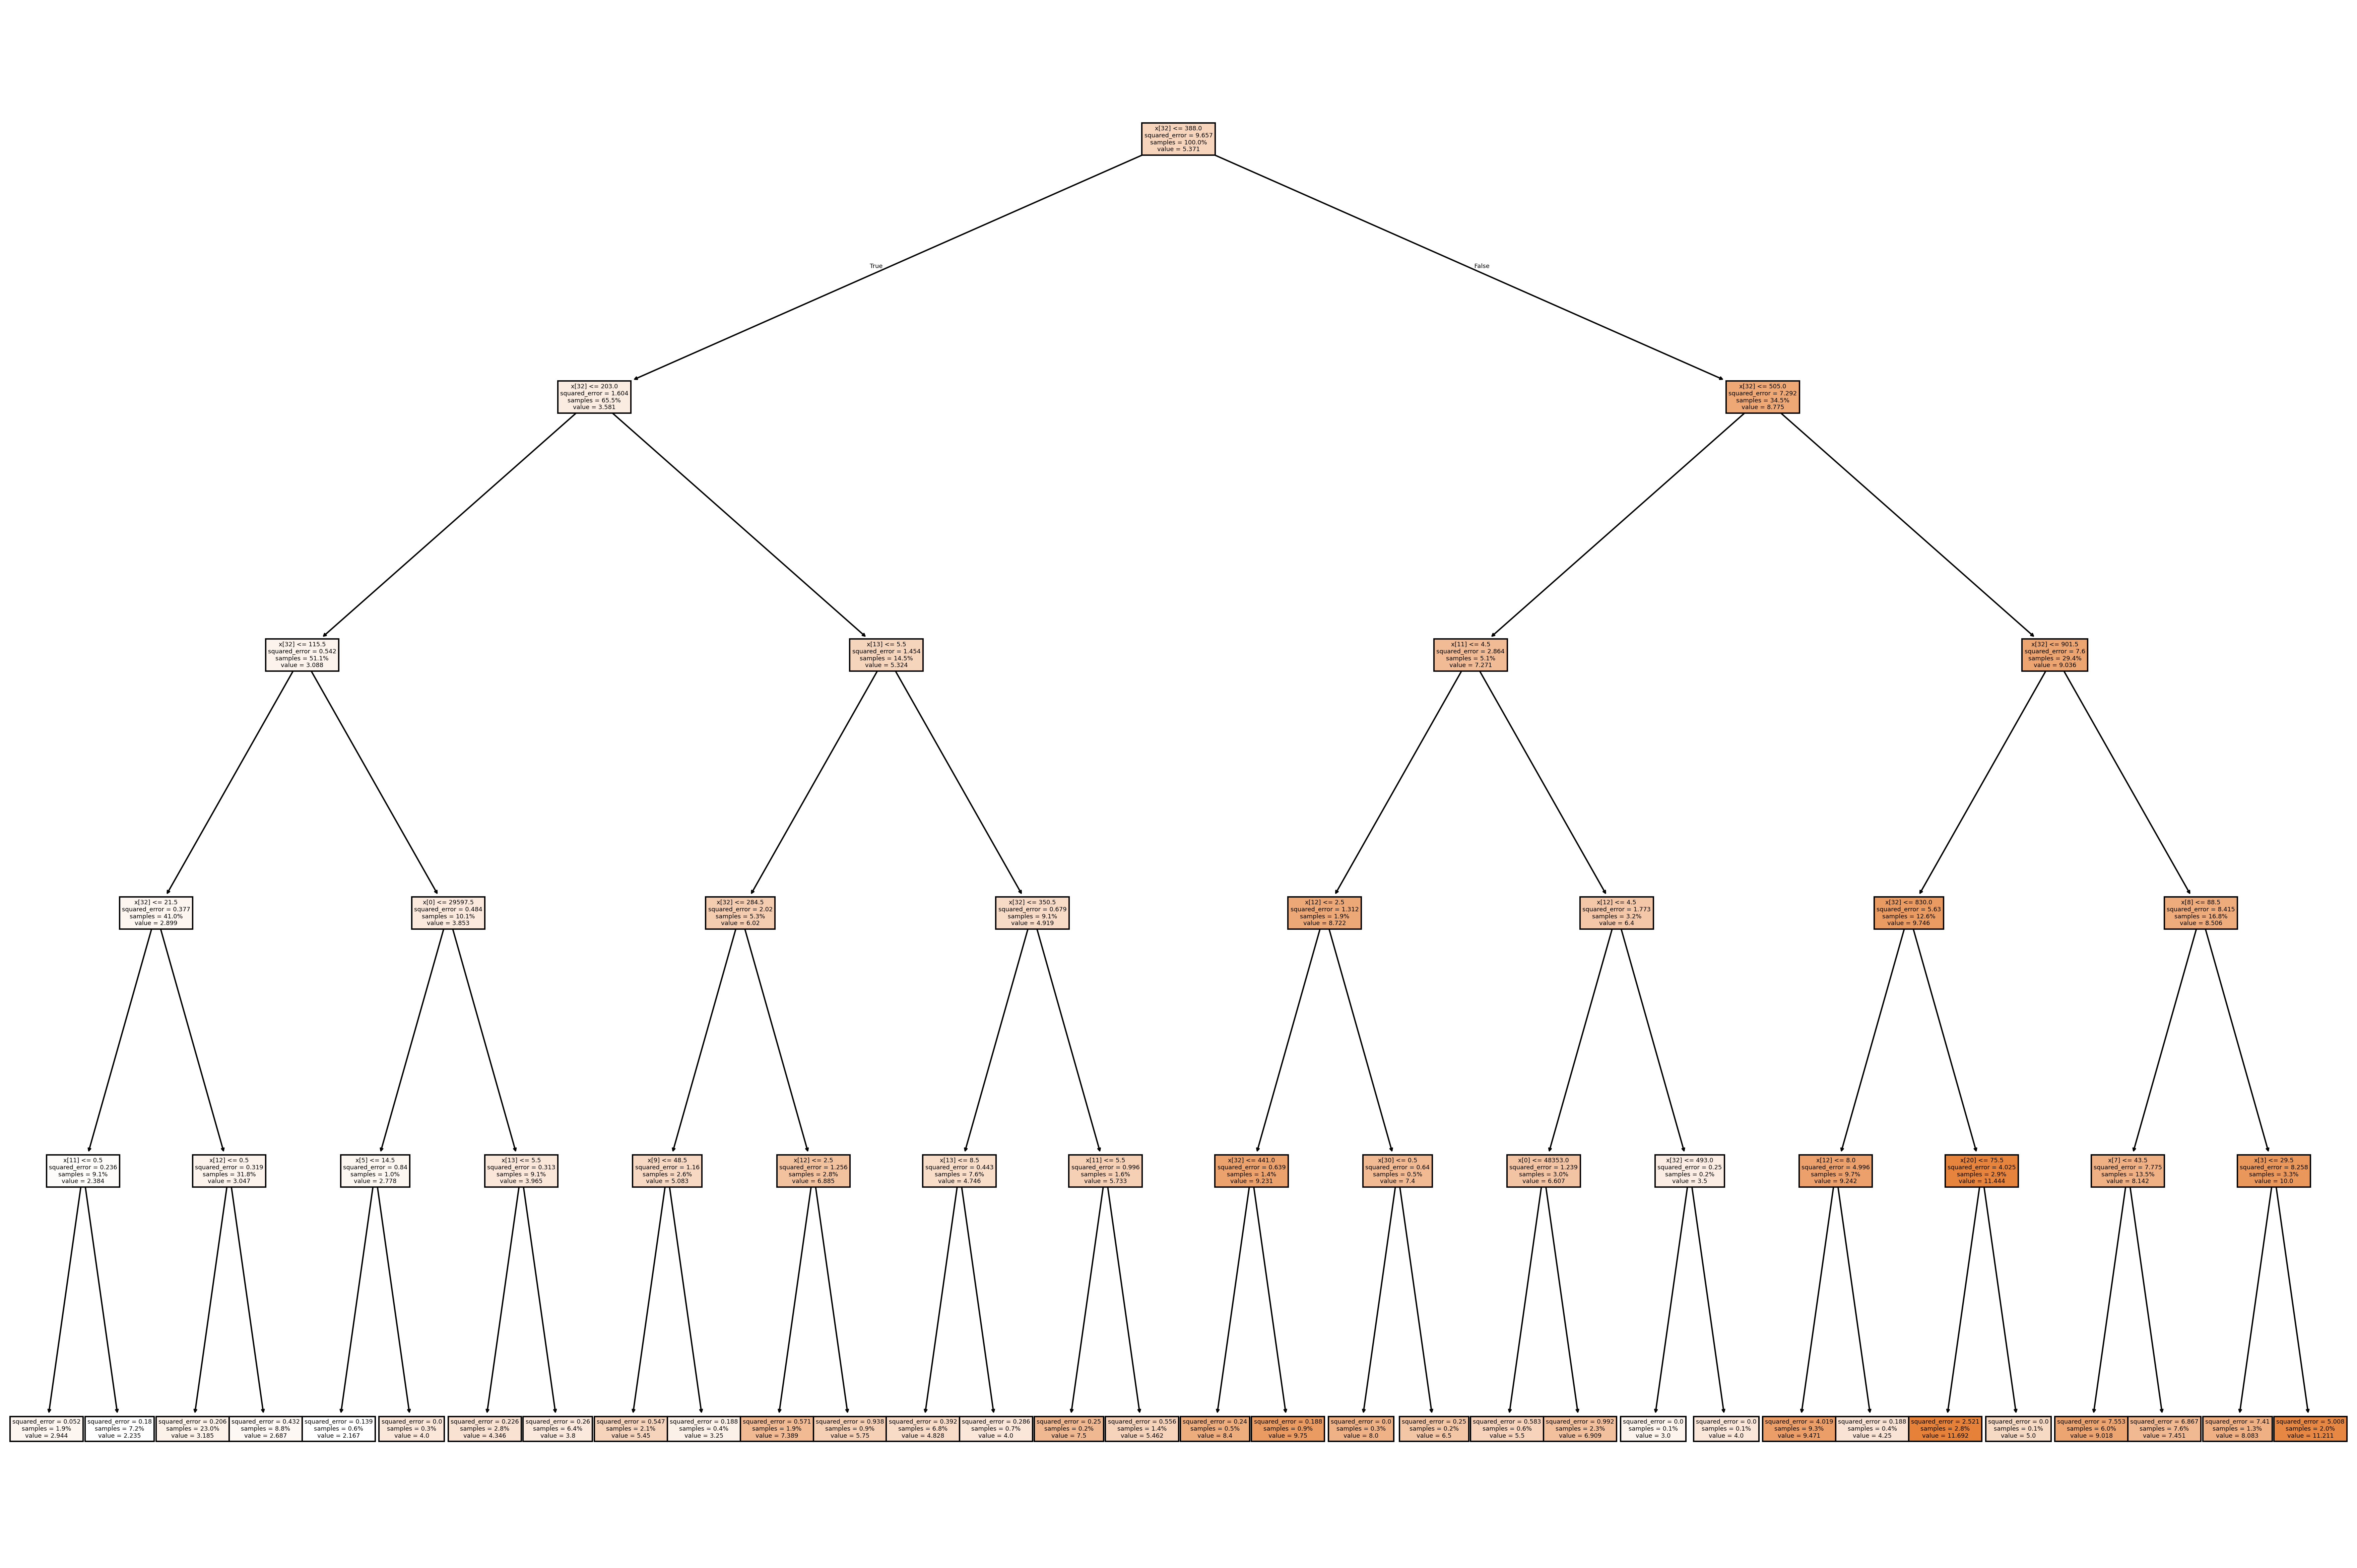

In [20]:
# Exibir a árvore de decisão como texto
tree_text = export_text(best_tree, feature_names=list(features.columns))
print(tree_text)

# Plotando a árvore de decisão
plt.figure(figsize=(30, 20), dpi=300)
plot_tree(best_tree, filled=True, proportion=True)
plt.show()

## Construção e Treinamento do Modelo de Rede Neural
Definimos e treinamos nosso modelo de rede neural.

In [14]:
normalizer = Normalization()
normalizer.adapt(X_train_scaled)

camadas = [
    normalizer,
    layers.Dense(8, activation='tanh'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='tanh'),
    layers.Dense(1, activation='linear')
]

# Constrói o modelo de rede neural
model = models.Sequential(deepcopy(camadas))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Treina o modelo
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=0.2)


Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 35.5456 - mean_absolute_error: 5.0973 - val_loss: 35.1398 - val_mean_absolute_error: 4.9458
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.4159 - mean_absolute_error: 4.8904 - val_loss: 33.1794 - val_mean_absolute_error: 4.7527
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.3898 - mean_absolute_error: 4.6915 - val_loss: 31.2815 - val_mean_absolute_error: 4.5711
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.5808 - mean_absolute_error: 4.5120 - val_loss: 29.4836 - val_mean_absolute_error: 4.4065
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.0201 - mean_absolute_error: 4.3567 - val_loss: 27.9546 - val_mean_absolute_error: 4.2606
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6522 - mean_absolute_error: 4.2161 - val_loss: 26.6161 - val_mean_absolute_error: 4.1271
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.4143 - mean_absolute_error: 4.0

## Avaliação do Modelo e Determinação da Melhor Época para Parar o Treinamento

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4686 - mean_absolute_error: 1.0753 
Test accuracy: 1.0591870546340942


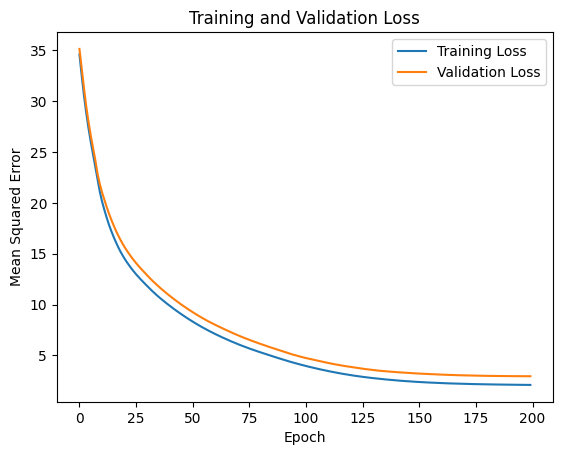

In [15]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc}')

# Visualização de Loss e MAE durante o Treinamento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


## Visualização de Perda durante o Treinamento
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair a partir da décima epoca de treino, o que indica que esta é aproximadamente a melhor época para parar de treinar e não gerar overfitting, e ainda sim obter um modelo satisfatório

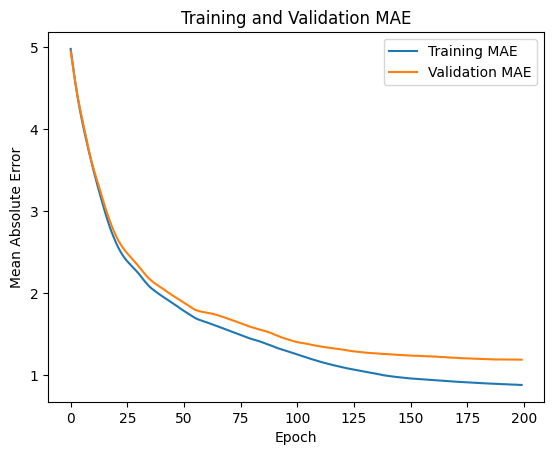

In [16]:
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

## Treinando com um número de épocas fixo
Com base no gráfico de loss e nas acurácias de treino e validação, nota-se que o ganho de acurácia e a redução do loss começa a decair significativamente a partir da 10ª epoca de treino. As melhores épocas para treinar um modelo definitivo estão entre a 10ª e a 35ª aproximadamente, provendo uma acurácia satisfatória, e sem overfitting. Vamos retreinar considerando a 25ª época:

In [17]:
## Retreinamento com um número de épocas otimizado
# Constrói o modelo de rede neural final
final_model = models.Sequential(deepcopy(camadas))

# Compilação do modelo
final_model.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mean_absolute_error'])

# Treinamento do modelo com número de épocas reduzido
history = final_model.fit(X_train_scaled, y_train, epochs=25, validation_split=0.2)

# Avaliação do modelo final
final_test_loss, final_test_mae = final_model.evaluate(X_test_scaled, y_test)
print(f'Final Test MAE: {final_test_mae}')

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 33.8482 - mean_absolute_error: 5.0143 - val_loss: 34.2152 - val_mean_absolute_error: 4.9722
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.3671 - mean_absolute_error: 4.8772 - val_loss: 32.8549 - val_mean_absolute_error: 4.8285
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.0452 - mean_absolute_error: 4.7359 - val_loss: 31.5813 - val_mean_absolute_error: 4.6811
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.8383 - mean_absolute_error: 4.5963 - val_loss: 30.4349 - val_mean_absolute_error: 4.5415
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.7586 - mean_absolute_error: 4.4650 - val_loss: 29.4196 - val_mean_absolute_error: 4.4157
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.7928 - mean_absolute_error: 4.3438 - val_loss: 28.5251 - val_mean_absolute_error: 4.3042
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.9346 - mean_absolute_error: 4.2352 - v

Uma época relativamente avançada, dentro do intervalo proposto ou até mais também pode ser selecionada, visando adquirir uma margem de erro (MAE ou MSE) menor, o que significaria números mais precisos, mas também reduziria o potencial do modelo em generalizar respostas para caso não previstos devido a uma especialização muito forte.